In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = np.load("./imagenet_val_25.npz", allow_pickle=True)
imgs = data["X"]
labels = data["y"]
map = data["label_map"]
map = map.tolist()

Text(0.5, 1.0, 'hay')

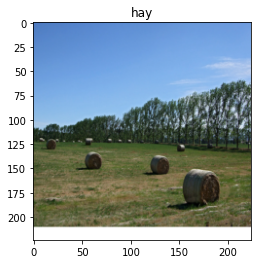

In [3]:
plt.imshow(imgs[0])
plt.title(map[labels[0]])

In [4]:
import torchvision
import torch

In [5]:
model = torchvision.models.squeezenet1_1(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

In [6]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

In [79]:
import torchvision.transforms as T
def preprocess(img, size=224):
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=mean,
              std=std),
    ])
    return transform(img)
def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / std)),
        T.Normalize(mean=(-mean).tolist(), std=[1, 1, 1]),
        # T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        # T.ToPILImage(),
    ])
    return transform(img)

In [9]:
def show_salency_map(x, y):
  # preprocess
  x = preprocess(x)
  x = x.unsqueeze(0)
  y = torch.tensor(y)

  

  model.eval()
  x.requires_grad = True
  pred = model(x)
  loss = pred[0, y]
  loss.backward()
  grad_data = x.grad.data

  # convert into img format and normalize
  grad_data = grad_data.squeeze(0)
  grad_data = torch.permute(grad_data, (1,2,0))
  out, _ = torch.max(torch.abs(grad_data), dim=2)
  out = (out - out.min()) / (out.max() - out.min())

  return out 


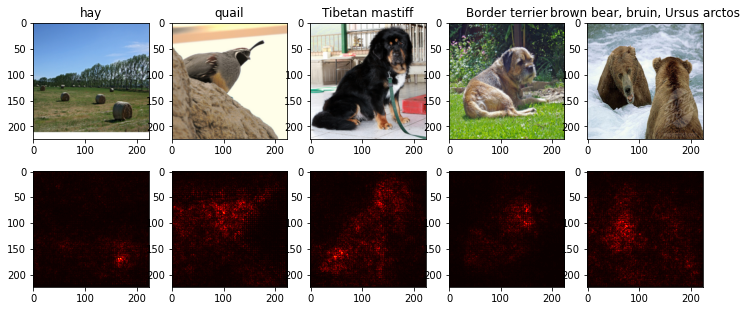

In [144]:
for i in range(5):
  out = show_salency_map(imgs[i], labels[i])
  plt.subplot(2, 5, i+1)
  plt.imshow(imgs[i])
  plt.title(map[labels[i]])
  plt.subplot(2, 5, i+6)
  plt.imshow(out, cmap=plt.cm.hot)
  plt.gcf().set_size_inches(12,5)

In [21]:
import torch.nn as nn

softmax = nn.Softmax()

In [148]:
map[labels[0]],map[2]

('hay',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias')

In [149]:
# fool model

# origin label:hay target label:white shark
x = imgs[0]
y = 2
img = None

# preprocess
x = preprocess(x)
# (1, 3, 224, 224)
x = x.unsqueeze(0)
y = torch.tensor(y)


model.eval()
img = x.clone()

for i in range(100):
  x = img.clone()
  x.requires_grad = True

  
  pred = model(x)
  
  # check prob
  prob = softmax(pred)
  if prob[0, y] > 0.95:
    print(prob[0, y])
    break
  
  loss = pred[0, y]
  loss.backward()
  grad_data = x.grad.data

  # gradient ascent
  img += grad_data



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.9905, grad_fn=<SelectBackward0>)


In [156]:
assert softmax(model(img)).argmax() == 2
assert softmax(model(preprocess(imgs[0]).unsqueeze(0))).argmax() == labels[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


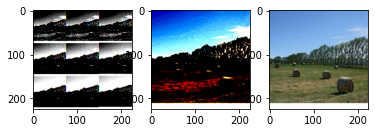

In [169]:
# big difference between reshape and permute
plt.subplot(1,3,1) 
plt.imshow(img.squeeze(0).reshape(224,224,3).numpy())
plt.subplot(1,3,2)
plt.imshow(img.squeeze(0).permute(1,2,0).numpy())
plt.subplot(1,3,3)
plt.imshow(deprocess(img).permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


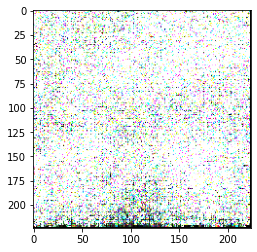

In [171]:
img_np = deprocess(img).permute(1,2,0).numpy()
plt.imshow(1000 * abs(imgs[0] / 255 - img_np))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


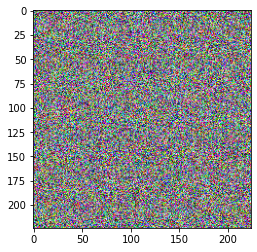

In [103]:
torch.manual_seed(3)
x = torch.rand((1,3,224,224))
plt.imshow(img.squeeze(0).reshape((224,224,3)).numpy())

In [131]:
blur_image = torchvision.transforms.GaussianBlur(3, sigma=0.5)

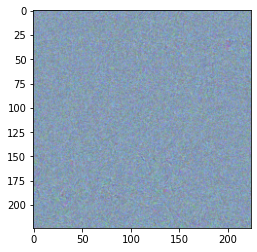

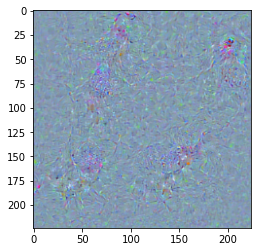

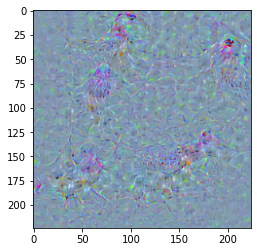

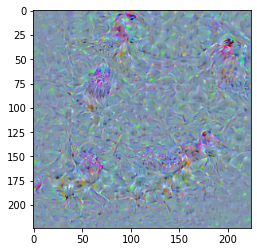

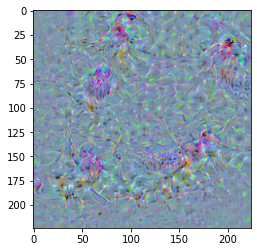

In [172]:
torch.manual_seed(3)
x = torch.rand((1,3,224,224))
tar_class = 8
l_r = 25
l2_reg = 1e-3
blur_every = 10
show_every = 20

img = x.clone()

for i in range(100):
  model.eval()
  x.requires_grad = True
  pred = model(x)
  loss = pred[0,tar_class] - l2_reg * torch.sum(x ** 2)
  loss.backward()
  grad_data = x.grad.data
  
  img += l_r * grad_data / grad_data.norm()
  x.grad.data.zero_()

  

  for c in range(3):
    low = float(- mean[c] / std[c])
    high = float((1.0 - mean[c])/ std[c])
    img[:, c].clamp_(min=low, max=high)


  if i % blur_every == 0:
    img = blur_image(img)
  x = img.clone()
  
    
  if i % show_every == 0:
    
    plt.imshow(deprocess(img).permute(1,2,0))
    plt.gcf().set_size_inches(4,4)
    plt.show()